In [1]:
import os
from datetime import datetime
import argparse
from msprime_models import * 
# from abinitio_tm import scaled_time_intervals
# from msprime_utils import scaled_time_intervals, get_het, round_coal_times, tm_counts, get_coal_data, round_bin_coal_data, normalise
from msprime_utils import *
from heatmaps_generate import *
from vcf_mhs import *
import numpy as np
import pdb
import math
import pandas as pd
from scipy.stats import entropy
import argparse
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np


In [2]:
# pecify the paramaters you want. Defaults as below

parser = argparse.ArgumentParser()
parser.add_argument("model",help="Specify the model to be used, as defined in msprime_models.")
parser.add_argument("-N","--N_0",help="Initial population size (Default is 1e+04",default=1e+04,type=int)
parser.add_argument("-L","--seq_length",help="Length of the sequence to be simulated (default 3e+07)",default=int(3e+07),type=int)
parser.add_argument("-mig","--migration_prop",help="Proportion of migrating population (default 0.3)",default=0.3,type=float)
parser.add_argument("-t","--time_splits",nargs=2,help="Time of splits, in generations (default t_1 = 2e+04, t_2 = 4e+04)",default = [int(2e+04),int(4e+04)])
parser.add_argument("-bin","--bin_length",help="The length (in bases) of the how wide you want each bin. (Default is 100)",default=100,type=int)
parser.add_argument("-o_coaldir","--output_coaldir",help="Output directory of coalescent data",default=os.getcwd() + '/coal_data/',type=str)
parser.add_argument("-o_coalname","--output_coalname",help="Output name for coal_data filename",default='',type=str)
parser.add_argument("-o_mhsdir","--output_mhsdir",help="Output dir for vcf and mhs data",default=os.getcwd() + '/vcf_mhs/',type=str)
parser.add_argument("-o_mhsname","--output_mhsname",help="Output name for vcf and mhs data",default = '',type=str)
parser.add_argument("-rho","--recomb_rate",help="Rate of recombination per bp per generation",default=2e-08,type=float)
parser.add_argument("-mew","--mut_rate",help="Rate of mutation per bp per generation",default=2e-08,type=float)
parser.add_argument("--suffix_time",help="Boolean, whether to write the time in to the files (useful for multi runs of the same simulation",action="store_true")
parser.add_argument("--print",help="Print the DemographicDebugger (from msprime) and the number of segratating sites",action="store_true")
parser.add_argument("--tree",help="Draw trees and info per segment",action="store_true")
args = parser.parse_args("m0001".split())

In [3]:
# scaled_time_intervals 

mu = 2e-08
alpha = 0.1
N_0 = 10000 # TODO, use sim
Tmax = 15
N_T = 50
T = [0]
for i in range(0,N_T): # TODO: should T have upper interval
        T.append( alpha*math.exp( (i/N_T)*math.log(1 + Tmax/alpha) - 1))
T_np = np.array(T) # convert to numpy
# scale these to generations with *2*N_0, as per Schiffels' instruction
T_scaled_np = T_np * 2 * N_0

## Mig01

History where 0.1 of lineages migrate to another population at time T_1, then return back at time T_2.

In [ ]:
path_mig01 =  '/home/trevor/ancestry/coal_data/mig01/'
files_mig01 = os.listdir(path_mig01)
print('Files are:\m')
for i in range(len(files_mig01)):
    print(f'File {i} is {path_mig01 + files_mig01[i]}')
seq_length = 150e+06 # length of sequence used for simulations
mig01_tms = np.zeros(shape=(N_T,N_T))



In [ ]:
for i in range(len(files_mig01)):
    print('on iteration {} of {}; file is {}'.format(i,len(files_mig01),files_mig01[i]))
    coal_data = np.loadtxt(path_mig01+files_mig01[i],comments="#")
    coal_times = round_bin_coal_data(seq_length,coal_data, args)
    coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)
    tm = tm_counts(coal_times_intervals,N_T=N_T)
    mig01_tms = mig01_tms + tm
    print(f'sum of mig01_tms is {sum(mig01_tms)}')
#     del tm, coal_data, coal_times, coal_times_intervals

In [ ]:
tm_norm_mig01 = normalise(mig01_tms,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd_mig01 = np.copy(tm_norm_mig01)
tm_nd_mig01[range(0,len(tm_nd_mig01)),range(0,len(tm_nd_mig01))] = 0
tm_nd_norm_mig01 = normalise(tm_nd_mig01,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd_mig01,'colmax'),title='Normalised true TM, for mig01') # show heatmap

## Matching_mig01

History with genuine population size changes, where the coalescent rate matches the mig01 history (as detected by PSMC)

In [ ]:
path_matchingmig01 =  '/home/trevor/ancestry/coal_data/matching_mig01/'
files_matchingmig01 = os.listdir(path_matchingmig01)
print('Files are:\m')
for i in range(len(files_matchingmig01)):
    print(f'File {i} is {path_matchingmig01 + files_matchingmig01[i]}')
seq_length = 150e+06 # length of sequence used for simulations
matchingmig01_tms = np.zeros(shape=(N_T,N_T))

# for i in range(len(files_matchingmig01)):
#     print('on iteration {} of {}; file is {}'.format(i,len(files_matchingmig01),files_matchingmig01[i]))
#     test = np.loadtxt(path_matchingmig01+files_matchingmig01[i],comments="#")
#     coal_times = round_bin_coal_data(seq_length,test, args)
#     coal_times_interval= round_coal_times(coal_times,T_scaled_np,N_T)
#     tm = tm_counts(coal_times_intervals,N_T=N_T)
#     matchingmig01_tms = matchingmig01_tms + tm
for i in range(len(files_matchingmig01)):
    print('on iteration {} of {}; file is {}'.format(i,len(files_matchingmig01),files_matchingmig01[i]))
    coal_data = np.loadtxt(path_matchingmig01+files_matchingmig01[i],comments="#")
    coal_times = round_bin_coal_data(seq_length,coal_data, args)
    coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)
    tm = tm_counts(coal_times_intervals,N_T=N_T)
    matchingmig01_tms = matchingmig01_tms + tm
    print(f'sum of mig01_tms is {sum(mig01_tms)}')
#     del tm, coal_data, coal_times, coal_times_intervals


In [ ]:
tm_norm_mmig01 = normalise(matchingmig01_tms,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd_mmig01 = np.copy(tm_norm_mmig01)
tm_nd_mmig01[range(0,len(tm_nd_mmig01)),range(0,len(tm_nd_mmig01))] = 0
tm_nd_norm_mmig01 = normalise(tm_nd_mmig01,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd_mmig01,'colmax'),title='Normalised true TM, for matchingmig01') # show heatmap
# heatmaps_seq(normalise(,'colmax'),title='Normalised true TM') # show heatmap


## Comparison for mig01 and matchingmig01

Compare the two

In [ ]:
def heatmaps_div2(matrix,title=''):
    cmaps = OrderedDict()
    cmaps['Diverging'] = [
        'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
        'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax1 = sns.heatmap(matrix, cmap=cmaps['Diverging'][11], center=0,yticklabels=False, xticklabels=False)
    ax1.set_title(title)
    ax1.add_patch(Rectangle((0, 34), 50, 7, fill=False, edgecolor='black', lw=1))
    # for i in range(len(matrix)):
    #     ax.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='blue', lw=3))
    # ax.set_title(plot_title)
    # ax.set_ylabel(ylabel='PSMC output')
    fig.show()
    # fig.savefig(heatmaps_path + sys.argv[4])
    return None

diff_mig01 = tm_nd_norm_mmig01 - tm_nd_norm_mig01
fig = heatmaps_div2(diff_mig01,title='Difference in matchingmig01 and mig01')
print(f'example values from the 20th column of this block are: {diff_mig01[33:41,20]}')
print(f'These correspond to the following values from the time intervals: {T_scaled_np[33:41]}') # this corresponds with the times at which structure occured


In [ ]:
KL_divergence_mig01 = []
for i in range(N_T):
    KL_div = entropy(tm_nd_norm_mmig01[:,i],tm_nd_norm_mig01[:,i])
    KL_divergence_mig01.append(KL_div)

print(KL_divergence)
print('\nmean KL_divergence is {}'.format(np.mean(np.array(KL_divergence))))
print('\nmedian KL_divergence is {}'.format(np.median(np.array(KL_divergence))))

In [ ]:
i = 2
entropy(tm_nd_norm_mig01[:,i],tm_nd_norm_mmig01[:,i])
test = entropy(tm_nd_norm_mmig01[:,i],tm_nd_norm_mig01[:,i])
np.isinf(test)

## Mig02 and Matchingmig01


In [ ]:
path_mig02 =  '/home/trevor/ancestry/coal_data/mig02/'
files_mig02 = os.listdir(path_mig02)
print('Files are:\m')
for i in range(len(files_mig02)):
    print(f'File {i} is {path_mig02 + files_mig02[i]}')
seq_length = 150e+06 # length of sequence used for simulations
mig02_tms = np.zeros(shape=(N_T,N_T))

for i in range(len(files_mig02)):
    print('on iteration {} of {}; file is {}'.format(i,len(files_mig02),files_mig02[i]))
    coal_data = np.loadtxt(path_mig02+files_mig02[i],comments="#")
    coal_times = round_bin_coal_data(seq_length,coal_data, args)
    coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)
    tm = tm_counts(coal_times_intervals,N_T=N_T)
    mig02_tms = mig02_tms + tm
    print(f'sum of mig02_tms is {sum(mig02_tms)}')
#     del tm, coal_data, coal_times, coal_times_intervals

tm_norm_mig02 = normalise(mig02_tms,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd_mig02 = np.copy(tm_norm_mig02)
tm_nd_mig02[range(0,len(tm_nd_mig02)),range(0,len(tm_nd_mig02))] = 0
tm_nd_norm_mig02 = normalise(tm_nd_mig02,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd_mig02,'colmax'),title='Normalised true TM, for mig02') # show heatmap


In [ ]:
path_matchingmig02 =  '/home/trevor/ancestry/coal_data/matching_mig02/'
files_matchingmig02 = os.listdir(path_matchingmig02)
print('Files are:\m')
for i in range(len(files_matchingmig02)):
    print(f'File {i} is {path_matchingmig02 + files_matchingmig02[i]}')
seq_length = 150e+06 # length of sequence used for simulations
mmig02_tms = np.zeros(shape=(N_T,N_T))

for i in range(len(files_matchingmig02)):
    print('on iteration {} of {}; file is {}'.format(i,len(files_matchingmig02),files_matchingmig02[i]))
    coal_data = np.loadtxt(path_matchingmig02+files_matchingmig02[i],comments="#")
    coal_times = round_bin_coal_data(seq_length,coal_data, args)
    coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)
    tm = tm_counts(coal_times_intervals,N_T=N_T)
    mmig02_tms = mmig02_tms + tm
    print(f'sum of mmig02_tms is {sum(mmig02_tms)}')
#     del tm, coal_data, coal_times, coal_times_intervals

tm_norm_mmig02 = normalise(mmig02_tms,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd_mmig02 = np.copy(tm_norm_mmig02)
tm_nd_mmig02[range(0,len(tm_nd_mmig02)),range(0,len(tm_nd_mmig02))] = 0
tm_nd_norm_mmig02 = normalise(tm_nd_mmig02,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd_mmig02,'colmax'),title='Normalised true TM, for mmig02') # show heatmap


In [ ]:
def heatmaps_div2(matrix,title=''):
    cmaps = OrderedDict()
    cmaps['Diverging'] = [
        'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
        'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax1 = sns.heatmap(matrix, cmap=cmaps['Diverging'][11], center=0,yticklabels=False, xticklabels=False)
    ax1.set_title(title)
    ax1.add_patch(Rectangle((0, 34), 50, 7, fill=False, edgecolor='black', lw=1))
    # for i in range(len(matrix)):
    #     ax.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='blue', lw=3))
    # ax.set_title(plot_title)
    # ax.set_ylabel(ylabel='PSMC output')
    fig.show()
    # fig.savefig(heatmaps_path + sys.argv[4])
    return None

diff_mig02 = tm_nd_norm_mmig02 - tm_nd_norm_mig02
fig = heatmaps_div2(diff_mig02,title='Difference in matchingmig02 and mig02')
print(f'example values from the 20th column of this block are: {diff_mig02[33:41,20]}')
print(f'These correspond to the following values from the time intervals: {T_scaled_np[33:41]}') # this corresponds with the times at which structure occured

KL_divergence_mig02 = []
for i in range(N_T):
    KL_div = entropy(tm_nd_norm_mmig02[:,i],tm_nd_norm_mig02[:,i])
    KL_divergence_mig02.append(KL_div)

# find out the non inf elements
not_infs = np.where(np.array(KL_divergence_mig02)<1)
# print(not_infs)
print(f'\n\nmean KL divergence for mig02 and matchingmig02 is {np.mean(np.array(KL_divergence_mig02)[not_infs])}')
print(f'with {N_T - len(not_infs[0])} infs')
print('\nmedian KL_divergence is {}'.format(np.median(np.array(KL_divergence_mig02))))

## Mig03 and Matchingmig03

In [ ]:
path_mig03 =  '/home/trevor/ancestry/coal_data/mig03/'
files_mig03 = os.listdir(path_mig03)
print('Files are:\m')
for i in range(len(files_mig03)):
    print(f'File {i} is {path_mig03 + files_mig03[i]}')
seq_length = 150e+06 # length of sequence used for simulations
mig03_tms = np.zeros(shape=(N_T,N_T))

for i in range(len(files_mig03)):
    print('on iteration {} of {}; file is {}'.format(i,len(files_mig03),files_mig03[i]))
    coal_data = np.loadtxt(path_mig03+files_mig03[i],comments="#")
    coal_times = round_bin_coal_data(seq_length,coal_data, args)
    coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)
    tm = tm_counts(coal_times_intervals,N_T=N_T)
    mig03_tms = mig03_tms + tm
    print(f'sum of mig03_tms is {sum(mig03_tms)}')
#     del tm, coal_data, coal_times, coal_times_intervals

tm_norm_mig03 = normalise(mig03_tms,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd_mig03 = np.copy(tm_norm_mig03)
tm_nd_mig03[range(0,len(tm_nd_mig03)),range(0,len(tm_nd_mig03))] = 0
tm_nd_norm_mig03 = normalise(tm_nd_mig03,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd_mig03,'colmax'),title='Normalised true TM, for mig03') # show heatmap

path_matchingmig03 =  '/home/trevor/ancestry/coal_data/matching_mig03/'
files_matchingmig03 = os.listdir(path_matchingmig03)
print('Files are:\m')
for i in range(len(files_matchingmig03)):
    print(f'File {i} is {path_matchingmig03 + files_matchingmig03[i]}')
seq_length = 150e+06 # length of sequence used for simulations
mmig03_tms = np.zeros(shape=(N_T,N_T))

for i in range(len(files_matchingmig03)):
    print('on iteration {} of {}; file is {}'.format(i,len(files_matchingmig03),files_matchingmig03[i]))
    coal_data = np.loadtxt(path_matchingmig03+files_matchingmig03[i],comments="#")
    coal_times = round_bin_coal_data(seq_length,coal_data, args)
    coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)
    tm = tm_counts(coal_times_intervals,N_T=N_T)
    mmig03_tms = mmig03_tms + tm
    print(f'sum of mmig03_tms is {sum(mmig03_tms)}')
#     del tm, coal_data, coal_times, coal_times_intervals

tm_norm_mmig03 = normalise(mmig03_tms,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd_mmig03 = np.copy(tm_norm_mmig03)
tm_nd_mmig03[range(0,len(tm_nd_mmig03)),range(0,len(tm_nd_mmig03))] = 0
tm_nd_norm_mmig03 = normalise(tm_nd_mmig03,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd_mmig03,'colmax'),title='Normalised true TM, for mmig03') # show heatmap

def heatmaps_div2(matrix,title=''):
    cmaps = OrderedDict()
    cmaps['Diverging'] = [
        'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
        'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax1 = sns.heatmap(matrix, cmap=cmaps['Diverging'][11], center=0,yticklabels=False, xticklabels=False)
    ax1.set_title(title)
    ax1.add_patch(Rectangle((0, 34), 50, 7, fill=False, edgecolor='black', lw=1))
    # for i in range(len(matrix)):
    #     ax.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='blue', lw=3))
    # ax.set_title(plot_title)
    # ax.set_ylabel(ylabel='PSMC output')
    fig.show()
    # fig.savefig(heatmaps_path + sys.argv[4])
    return None

diff_mig03 = tm_nd_norm_mmig03 - tm_nd_norm_mig03
fig = heatmaps_div2(diff_mig03,title='Difference in matchingmig03 and mig03')
print(f'example values from the 20th column of this block are: {diff_mig03[33:41,20]}')
print(f'These correspond to the following values from the time intervals: {T_scaled_np[33:41]}') # this corresponds with the times at which structure occured

KL_divergence_mig03 = []
for i in range(N_T):
    KL_div = entropy(tm_nd_norm_mmig03[:,i],tm_nd_norm_mig03[:,i])
    KL_divergence_mig03.append(KL_div)

# find out the non inf elements
not_infs = np.where(np.array(KL_divergence_mig03)<1)
# print(not_infs)
print(f'\n\nmean KL divergence for mig03 and matchingmig03 is {np.mean(np.array(KL_divergence_mig03)[not_infs])}')
print(f'with {N_T - len(not_infs[0])} infs')
print('\nmedian KL_divergence is {}'.format(np.median(np.array(KL_divergence_mig03))))


## Mig04 and matching mig04

In [ ]:
path_mig04 =  '/home/trevor/ancestry/coal_data/mig04/'
files_mig04 = os.listdir(path_mig04)
print('Files are:\m')
for i in range(len(files_mig04)):
    print(f'File {i} is {path_mig04 + files_mig04[i]}')
seq_length = 150e+06 # length of sequence used for simulations
mig04_tms = np.zeros(shape=(N_T,N_T))

for i in range(len(files_mig04)):
    print('on iteration {} of {}; file is {}'.format(i,len(files_mig04),files_mig04[i]))
    coal_data = np.loadtxt(path_mig04+files_mig04[i],comments="#")
    coal_times = round_bin_coal_data(seq_length,coal_data, args)
    coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)
    tm = tm_counts(coal_times_intervals,N_T=N_T)
    mig04_tms = mig04_tms + tm
    print(f'sum of mig04_tms is {sum(mig04_tms)}')
#     del tm, coal_data, coal_times, coal_times_intervals

tm_norm_mig04 = normalise(mig04_tms,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd_mig04 = np.copy(tm_norm_mig04)
tm_nd_mig04[range(0,len(tm_nd_mig04)),range(0,len(tm_nd_mig04))] = 0
tm_nd_norm_mig04 = normalise(tm_nd_mig04,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd_mig04,'colmax'),title='Normalised true TM, for mig04') # show heatmap

path_matchingmig04 =  '/home/trevor/ancestry/coal_data/matching_mig04/'
files_matchingmig04 = os.listdir(path_matchingmig04)
print('Files are:\m')
for i in range(len(files_matchingmig04)):
    print(f'File {i} is {path_matchingmig04 + files_matchingmig04[i]}')
seq_length = 150e+06 # length of sequence used for simulations
mmig04_tms = np.zeros(shape=(N_T,N_T))

for i in range(len(files_matchingmig04)):
    print('on iteration {} of {}; file is {}'.format(i,len(files_matchingmig04),files_matchingmig04[i]))
    coal_data = np.loadtxt(path_matchingmig04+files_matchingmig04[i],comments="#")
    coal_times = round_bin_coal_data(seq_length,coal_data, args)
    coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)
    tm = tm_counts(coal_times_intervals,N_T=N_T)
    mmig04_tms = mmig04_tms + tm
    print(f'sum of mmig04_tms is {sum(mmig04_tms)}')
#     del tm, coal_data, coal_times, coal_times_intervals

tm_norm_mmig04 = normalise(mmig04_tms,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd_mmig04 = np.copy(tm_norm_mmig04)
tm_nd_mmig04[range(0,len(tm_nd_mmig04)),range(0,len(tm_nd_mmig04))] = 0
tm_nd_norm_mmig04 = normalise(tm_nd_mmig04,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd_mmig04,'colmax'),title='Normalised true TM, for mmig04') # show heatmap

def heatmaps_div2(matrix,title=''):
    cmaps = OrderedDict()
    cmaps['Diverging'] = [
        'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
        'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax1 = sns.heatmap(matrix, cmap=cmaps['Diverging'][11], center=0,yticklabels=False, xticklabels=False)
    ax1.set_title(title)
    ax1.add_patch(Rectangle((0, 34), 50, 7, fill=False, edgecolor='black', lw=1))
    # for i in range(len(matrix)):
    #     ax.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='blue', lw=3))
    # ax.set_title(plot_title)
    # ax.set_ylabel(ylabel='PSMC output')
    fig.show()
    # fig.savefig(heatmaps_path + sys.argv[4])
    return None

diff_mig04 = tm_nd_norm_mmig04 - tm_nd_norm_mig04
fig = heatmaps_div2(diff_mig04,title='Difference in matchingmig04 and mig04')
print(f'example values from the 20th column of this block are: {diff_mig04[33:41,20]}')
print(f'These correspond to the following values from the time intervals: {T_scaled_np[33:41]}') # this corresponds with the times at which structure occured

KL_divergence_mig04 = []
for i in range(N_T):
    KL_div = entropy(tm_nd_norm_mmig04[:,i],tm_nd_norm_mig04[:,i])
    KL_divergence_mig04.append(KL_div)

# find out the non inf elements
not_infs = np.where(np.array(KL_divergence_mig04)<1)
# print(not_infs)
print(f'\n\nmean KL divergence for mig04 and matchingmig04 is {np.mean(np.array(KL_divergence_mig04)[not_infs])}')
print(f'with {N_T - len(not_infs[0])} infs')
print('\nmedian KL_divergence is {}'.format(np.median(np.array(KL_divergence_mig04))))


## Mig05 and matchingmig05

In [ ]:
path_mig05 =  '/home/trevor/ancestry/coal_data/mig05/'
files_mig05 = os.listdir(path_mig05)
print('Files are:\m')
for i in range(len(files_mig05)):
    print(f'File {i} is {path_mig05 + files_mig05[i]}')
seq_length = 150e+06 # length of sequence used for simulations
mig05_tms = np.zeros(shape=(N_T,N_T))

for i in range(len(files_mig05)):
    print('on iteration {} of {}; file is {}'.format(i,len(files_mig05),files_mig05[i]))
    coal_data = np.loadtxt(path_mig05+files_mig05[i],comments="#")
    coal_times = round_bin_coal_data(seq_length,coal_data, args)
    coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)
    tm = tm_counts(coal_times_intervals,N_T=N_T)
    mig05_tms = mig05_tms + tm
    print(f'sum of mig05_tms is {sum(mig05_tms)}')
#     del tm, coal_data, coal_times, coal_times_intervals

tm_norm_mig05 = normalise(mig05_tms,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd_mig05 = np.copy(tm_norm_mig05)
tm_nd_mig05[range(0,len(tm_nd_mig05)),range(0,len(tm_nd_mig05))] = 0
tm_nd_norm_mig05 = normalise(tm_nd_mig05,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd_mig05,'colmax'),title='Normalised true TM, for mig05') # show heatmap

path_matchingmig05 =  '/home/trevor/ancestry/coal_data/matching_mig05/'
files_matchingmig05 = os.listdir(path_matchingmig05)
print('Files are:\m')
for i in range(len(files_matchingmig05)):
    print(f'File {i} is {path_matchingmig05 + files_matchingmig05[i]}')
seq_length = 150e+06 # length of sequence used for simulations
mmig05_tms = np.zeros(shape=(N_T,N_T))

for i in range(len(files_matchingmig05)):
    print('on iteration {} of {}; file is {}'.format(i,len(files_matchingmig05),files_matchingmig05[i]))
    coal_data = np.loadtxt(path_matchingmig05+files_matchingmig05[i],comments="#")
    coal_times = round_bin_coal_data(seq_length,coal_data, args)
    coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)
    tm = tm_counts(coal_times_intervals,N_T=N_T)
    mmig05_tms = mmig05_tms + tm
    print(f'sum of mmig05_tms is {sum(mmig05_tms)}')
#     del tm, coal_data, coal_times, coal_times_intervals

tm_norm_mmig05 = normalise(mmig05_tms,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd_mmig05 = np.copy(tm_norm_mmig05)
tm_nd_mmig05[range(0,len(tm_nd_mmig05)),range(0,len(tm_nd_mmig05))] = 0
tm_nd_norm_mmig05 = normalise(tm_nd_mmig05,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd_mmig05,'colmax'),title='Normalised true TM, for mmig05') # show heatmap

def heatmaps_div2(matrix,title=''):
    cmaps = OrderedDict()
    cmaps['Diverging'] = [
        'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
        'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax1 = sns.heatmap(matrix, cmap=cmaps['Diverging'][11], center=0,yticklabels=False, xticklabels=False)
    ax1.set_title(title)
    ax1.add_patch(Rectangle((0, 34), 50, 7, fill=False, edgecolor='black', lw=1))
    # for i in range(len(matrix)):
    #     ax.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='blue', lw=3))
    # ax.set_title(plot_title)
    # ax.set_ylabel(ylabel='PSMC output')
    fig.show()
    # fig.savefig(heatmaps_path + sys.argv[4])
    return None

diff_mig05 = tm_nd_norm_mmig05 - tm_nd_norm_mig05
fig = heatmaps_div2(diff_mig05,title='Difference in matchingmig05 and mig05')
print(f'example values from the 20th column of this block are: {diff_mig05[33:41,20]}')
print(f'These correspond to the following values from the time intervals: {T_scaled_np[33:41]}') # this corresponds with the times at which structure occured

KL_divergence_mig05 = []
for i in range(N_T):
    KL_div = entropy(tm_nd_norm_mmig05[:,i],tm_nd_norm_mig05[:,i])
    KL_divergence_mig05.append(KL_div)

# find out the non inf elements
not_infs = np.where(np.array(KL_divergence_mig05)<1)
# print(not_infs)
print(f'\n\nmean KL divergence for mig05 and matchingmig05 is {np.mean(np.array(KL_divergence_mig05)[not_infs])}')
print(f'with {N_T - len(not_infs[0])} infs')
print('\nmedian KL_divergence is {}'.format(np.median(np.array(KL_divergence_mig05))))


## Contmig5e4 and matching_contmig5e4

In [16]:
def round_coal_times2(coal_times,T_scaled_np,N_T):
    # coal_times are the (exact) coalescent times along a sequence, as given by ms prime
    # T_scaled_np are the scaled time intervals (in a np aray)
    # N_T is the number of hidden states
    coal_times_intervals = [] 
    for i in range(0,len(coal_times)):
#         print(f'i is {i}')
        diff = coal_times[i] - T_scaled_np
        diff_pos = diff[diff >0]
        where = np.argmin(diff_pos) # find closest interval
        if where == N_T: #TODO find a better fix for this. Have extended T to include upper interval
            where = where - 1
        coal_times_intervals.append(where) 
    return coal_times_intervals


In [4]:
path_contmig5e4 =  '/home/trevor/ancestry/coal_data/contmig5e4/'
files_contmig5e4 = os.listdir(path_contmig5e4)
print('Files are:\m')
files_contmig5e4.remove('20201210_const_mig0001_mig0_092904.txt')
seq_length = 150e+06 # length of sequence used for simulations
contmig5e4_tms = np.zeros(shape=(N_T,N_T))
for i in range(len(files_contmig5e4)):
    print(f'File {i} is {path_contmig5e4 + files_contmig5e4[i]}')


Files are:\m
File 0 is /home/trevor/ancestry/coal_data/contmig5e4/20201210_const_mig0001_mig0_095444.txt
File 1 is /home/trevor/ancestry/coal_data/contmig5e4/20201210_const_mig0001_mig0_095817.txt
File 2 is /home/trevor/ancestry/coal_data/contmig5e4/20201210_const_mig0001_mig0_100140.txt
File 3 is /home/trevor/ancestry/coal_data/contmig5e4/20201210_const_mig0001_mig0_100516.txt
File 4 is /home/trevor/ancestry/coal_data/contmig5e4/20201210_const_mig0001_mig0_102658.txt
File 5 is /home/trevor/ancestry/coal_data/contmig5e4/20201210_const_mig0001_mig0_103025.txt
File 6 is /home/trevor/ancestry/coal_data/contmig5e4/20201210_const_mig0001_mig0_103354.txt
File 7 is /home/trevor/ancestry/coal_data/contmig5e4/20201210_const_mig0001_mig0_103718.txt
File 8 is /home/trevor/ancestry/coal_data/contmig5e4/20201210_const_mig0001_mig0_104048.txt
File 9 is /home/trevor/ancestry/coal_data/contmig5e4/20201210_const_mig0001_mig0_104411.txt
File 10 is /home/trevor/ancestry/coal_data/contmig5e4/20201210_cons

In [18]:
# i = 0

# print('on iteration {} of {}; file is {}'.format(i,len(files_contmig5e4),files_contmig5e4[i]))
# coal_data = np.loadtxt(path_contmig5e4+files_contmig5e4[i],comments="#")
# coal_times = round_bin_coal_data(seq_length,coal_data, args)
# print(f'length of coal_data is {len(coal_data)}')
# print(f'length of coal_times is {len(coal_times)}')

# # coal_times_intervals = round_coal_times2(coal_times,T_scaled_np,N_T)
# # tm = tm_counts(coal_times_intervals,N_T=N_T)
# # mig01_tms = mig01_tms + tm
# # print(f'sum of mig01_tms is {sum(mig01_tms)}')

In [5]:
for i in range(len(files_contmig5e4)):
    print('on iteration {} of {}; file is {}'.format(i,len(files_contmig5e4),files_contmig5e4[i]))
    coal_data = np.loadtxt(path_contmig5e4+files_contmig5e4[i],comments="#")
    coal_times = round_bin_coal_data(seq_length,coal_data, args)
    coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)
    tm = tm_counts(coal_times_intervals,N_T=N_T)
    contmig5e4_tms = contmig5e4_tms + tm
    print(f'sum of contmig5e4_tms is {sum(contmig5e4_tms)}')
#     del tm, coal_data, coal_times, coal_times_intervals

on iteration 0 of 20; file is 20201210_const_mig0001_mig0_095444.txt
sum of contmig5e4_tms is [47718.  5681.  4863.  3579.  6032.  5894. 11260.  7968. 13984. 13306.
 12310. 14538. 13634. 19622. 16563. 21833. 22293. 23155. 25548. 26512.
 30988. 34935. 31227. 36736. 36898. 43717. 43098. 46496. 52265. 51894.
 52201. 50362. 57122. 56905. 33866. 30326. 30757. 31145. 32732. 32159.
 40665. 61384. 56613. 47989. 39686. 33797. 26086. 20740. 14506. 26411.]
on iteration 1 of 20; file is 20201210_const_mig0001_mig0_095817.txt
sum of contmig5e4_tms is [ 93014.   8996.  11394.   9578.  14077.  15609.  19022.  21063.  21594.
  26148.  25061.  25984.  33170.  39670.  40049.  43978.  43075.  48528.
  50820.  54633.  58476.  70096.  66771.  75146.  76814.  87179.  89105.
  93659. 101325. 103465. 103757. 102551. 112456. 111227.  66704.  56988.
  60740.  63891.  63975.  64451.  78221. 123365. 112549.  93764.  77816.
  66474.  51315.  40411.  28695.  53149.]
on iteration 2 of 20; file is 20201210_const_mig0

sum of contmig5e4_tms is [ 924647.  103394.  114145.  132684.  146065.  145284.  163926.  180175.
  194703.  225391.  237766.  258239.  271980.  309221.  339446.  370606.
  388284.  442944.  464488.  502215.  550516.  599080.  628329.  666396.
  711474.  748421.  802823.  843544.  880373.  913391.  941987.  974601.
  991403.  992981.  590870.  523695.  539680.  562329.  571356.  583734.
  697967. 1111013.  986638.  848844.  707462.  582652.  458673.  348524.
  256046.  469577.]
on iteration 18 of 20; file is 20201210_const_mig0001_mig0_112437.txt
sum of contmig5e4_tms is [ 981296.  108517.  120663.  141313.  152644.  151901.  173287.  192878.
  205948.  237060.  252127.  271780.  290640.  327917.  355748.  390441.
  411641.  467936.  491333.  527672.  581096.  628858.  661991.  702680.
  749923.  791057.  847190.  890521.  928869.  964404.  996484. 1025297.
 1044284. 1046507.  624013.  552949.  570997.  594031.  602355.  616604.
  735828. 1174091. 1041963.  895566.  748081.  614304.  4

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


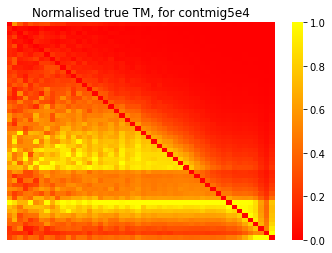

In [6]:
tm_norm_contmig5e4 = normalise(contmig5e4_tms,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd_contmig5e4 = np.copy(tm_norm_contmig5e4)
tm_nd_contmig5e4[range(0,len(tm_nd_contmig5e4)),range(0,len(tm_nd_contmig5e4))] = 0
tm_nd_norm_contmig5e4 = normalise(tm_nd_contmig5e4,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd_contmig5e4,'colmax'),title='Normalised true TM, for contmig5e4') # show heatmap
# heatmaps_seq(normalise(,'colmax'),title='Normalised true TM') # show heatmap


In [11]:
path_mcontmig5e4 =  '/home/trevor/ancestry/coal_data/matching_contmig5e4/'
files_mcontmig5e4 = os.listdir(path_mcontmig5e4)
files_mcontmig5e4.remove('20201210_double_m0002_mig20_191923.txt')
print('Files are:\n')
seq_length = 150e+06 # length of sequence used for simulations
mcontmig5e4_tms = np.zeros(shape=(N_T,N_T))
for i in range(len(files_mcontmig5e4)):
    print(f'File {i} is {path_mcontmig5e4 + files_mcontmig5e4[i]}')

for i in range(len(files_mcontmig5e4)):
    print('on iteration {} of {}; file is {}'.format(i,len(files_mcontmig5e4),files_mcontmig5e4[i]))
    coal_data = np.loadtxt(path_mcontmig5e4+files_mcontmig5e4[i],comments="#")
    coal_times = round_bin_coal_data(seq_length,coal_data, args)
    coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)
    tm = tm_counts(coal_times_intervals,N_T=N_T)
    mcontmig5e4_tms = mcontmig5e4_tms + tm
    print(f'sum of mcontmig5e4_tms is {sum(mcontmig5e4_tms)}')
#     del tm, coal_data, coal_times, coal_times_intervals




Files are:

File 0 is /home/trevor/ancestry/coal_data/matching_contmig5e4/20201212_double_m0002_mig20_074510.txt
File 1 is /home/trevor/ancestry/coal_data/matching_contmig5e4/20201212_double_m0002_mig20_074801.txt
File 2 is /home/trevor/ancestry/coal_data/matching_contmig5e4/20201212_double_m0002_mig20_075057.txt
File 3 is /home/trevor/ancestry/coal_data/matching_contmig5e4/20201212_double_m0002_mig20_075356.txt
File 4 is /home/trevor/ancestry/coal_data/matching_contmig5e4/20201212_double_m0002_mig20_075658.txt
File 5 is /home/trevor/ancestry/coal_data/matching_contmig5e4/20201212_double_m0002_mig20_075957.txt
File 6 is /home/trevor/ancestry/coal_data/matching_contmig5e4/20201212_double_m0002_mig20_080249.txt
File 7 is /home/trevor/ancestry/coal_data/matching_contmig5e4/20201212_double_m0002_mig20_080539.txt
File 8 is /home/trevor/ancestry/coal_data/matching_contmig5e4/20201212_double_m0002_mig20_080841.txt
File 9 is /home/trevor/ancestry/coal_data/matching_contmig5e4/20201212_double_m

sum of mcontmig5e4_tms is [777299.  72144.  73532.  97442. 103101. 125143. 129111. 130098. 141594.
 172510. 176987. 201842. 213177. 234240. 255328. 299219. 297833. 337918.
 363457. 394480. 435173. 457394. 474127. 521487. 568240. 593634. 619984.
 642682. 689825. 716394. 746131. 755965. 768987. 734179. 400315. 421411.
 428093. 449266. 457695. 464075. 543597. 875730. 761346. 662323. 559482.
 455820. 359855. 271802. 199983. 368536.]
on iteration 14 of 20; file is 20201212_double_m0002_mig20_082633.txt
sum of mcontmig5e4_tms is [827059.  79764.  80192. 103903. 110757. 135587. 142893. 137701. 152781.
 185306. 193606. 215112. 229737. 248991. 276458. 321490. 320110. 361306.
 389331. 421854. 464136. 489145. 511011. 556739. 607436. 634527. 665247.
 689996. 739273. 768614. 799247. 810810. 823491. 786547. 428498. 449994.
 457956. 479613. 489190. 497862. 582685. 936488. 815098. 711813. 597744.
 487236. 384882. 291212. 214436. 395121.]
on iteration 15 of 20; file is 20201212_double_m0002_mig20_08293

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


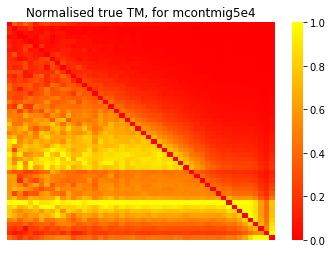

In [12]:
tm_norm_mcontmig5e4 = normalise(mcontmig5e4_tms,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd_mcontmig5e4 = np.copy(tm_norm_mcontmig5e4)
tm_nd_mcontmig5e4[range(0,len(tm_nd_mcontmig5e4)),range(0,len(tm_nd_mcontmig5e4))] = 0
tm_nd_norm_mcontmig5e4 = normalise(tm_nd_mcontmig5e4,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd_mcontmig5e4,'colmax'),title='Normalised true TM, for mcontmig5e4') # show heatmap
# heatmaps_seq(normalise(,'colmax'),title='Normalised true TM') # show heatmap


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


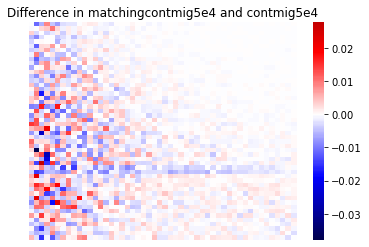

In [14]:
diff_contmig5e4 = tm_nd_norm_mcontmig5e4 - tm_nd_norm_contmig5e4
fig = heatmaps_div(diff_contmig5e4,title='Difference in matchingcontmig5e4 and contmig5e4')



## Matching test

In [19]:
def const_mig5e4(seq_length,T_1,T_2,print_):
    N_A0 = 1e+04
    N_B0 =  1e+04
    m = 5e-04
    
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A0, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N_B0, growth_rate=0)
    ]
    migration_matrix = [[0,0],[0,0]]
    demographic_events = [
        msprime.MigrationRateChange(time = T_1,rate = m, matrix_index=(0,1)),
        msprime.MigrationRateChange(time = T_1,rate = m, matrix_index=(1,0)),
        msprime.MigrationRateChange(time = T_2,rate = 0, matrix_index=(0,1)),
        msprime.MigrationRateChange(time = T_2,rate = 0, matrix_index=(1,0)),
        msprime.MassMigration(time=T_2, source =0, destination =1, proportion = 1)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,migration_matrix=migration_matrix,
        demographic_events=demographic_events)
    if print_:
        print('Demographic history:\n')
        dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim


def double_mX(N_0,mig_prop,T_1,T_2,seq_length,print_):
    # here mig_prop is the percentage change in N_0 between times T_1 and T_2
    # use this to match contmig5e4
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_0,growth_rate=0)
    ]
    migration_matrix = [
        [0],
        ]
    demographic_events = [
        msprime.PopulationParametersChange(time=T_1, initial_size=N_0*mig_prop),
        msprime.PopulationParametersChange(time=T_2, initial_size=N_0)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        demographic_events=demographic_events)
    if print_:
        dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           migration_matrix=migration_matrix,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,mutation_rate=2e-08)
    return sim



In [20]:
mig5e4 = 5e-04

print('Running sim_mig')
sim_mig = const_mig5e4(150e+06,2e+04,2e+04,True)
print('sim_mig finished')
print('Running sim_double')
sim_double = double_mX(1e+04,2,2e+04,4e+04,seq_length,True)
print('sim_double finished')


Running sim_mig
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 20000.0
   - Migration rate change for (0, 1) to 0.0005
   - Migration rate change for (1, 0) to 0.0005
   - Migration rate change for (0, 1) to 0
   - Migration rate change for (1, 0) to 0
   - Mass migration: Lineages moved with probability 1 backwards in time with source 0 & dest 1
                     (equivalent to migration from 1 to 0 forwards in time)
Epoch: 20000.0 -- inf generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

sim_mig finished
Runni

In [26]:
parser = argparse.ArgumentParser()
parser.add_argument("model",help="Specify the model to be used, as defined in msprime_models.")
parser.add_argument("--print",help="Print the DemographicDebugger (from msprime) and the number of segratating sites",action="store_true")
parser.add_argument("--tree",help="Draw trees and info per segment",action="store_true")
parser.add_argument("-bin","--bin_length",help="The length (in bases) of the how wide you want each bin. (Default is 100)",default=100,type=int)
parser.add_argument("-N_T","--Number_of_states",help="The number of states you want, for the time intervals (Default is 32)",default=32,type=int)
args = parser.parse_args("const_mig0003".split())


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


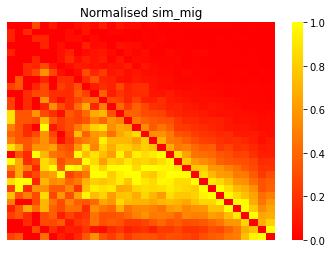

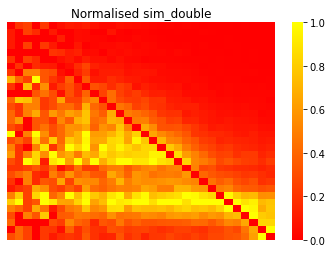

In [27]:
tmrca_data = get_coal_data(sim_mig, args) # get true coalescent 
coal_times = round_bin_coal_data(sim_mig.sequence_length,tmrca_data, args) # partition coalescent data into bins  
T_scaled, T, N_0 = scaled_time_intervals(sim_mig,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals = round_coal_times(coal_times,T_scaled,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm = tm_counts(coal_times_intervals,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd = np.copy(tm)
tm_nd[range(0,len(tm)),range(0,len(tm))] = 0
tm_nd_norm = normalise(tm_nd,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd,'colmax'),title='Normalised sim_mig') # show heatmap

tmrca_data = get_coal_data(sim_double, args) # get true coalescent 
coal_times = round_bin_coal_data(sim_double.sequence_length,tmrca_data, args) # partition coalescent data into bins  
T_scaled, T, N_0 = scaled_time_intervals(sim_double,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals = round_coal_times(coal_times,T_scaled,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm = tm_counts(coal_times_intervals,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd = np.copy(tm)
tm_nd[range(0,len(tm)),range(0,len(tm))] = 0
tm_nd_norm = normalise(tm_nd,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd,'colmax'),title='Normalised sim_double') # show heatmap


## Test on more data

Files are:\m
File 0 is /home/trevor/ancestry/coal_data/pscmatch20201214/pscmatch20201214_195238.txt
File 1 is /home/trevor/ancestry/coal_data/pscmatch20201214/pscmatch20201214_195810.txt
File 2 is /home/trevor/ancestry/coal_data/pscmatch20201214/pscmatch20201214_200149.txt
File 3 is /home/trevor/ancestry/coal_data/pscmatch20201214/pscmatch20201214_201938.txt
File 4 is /home/trevor/ancestry/coal_data/pscmatch20201214/pscmatch20201214_202321.txt
File 5 is /home/trevor/ancestry/coal_data/pscmatch20201214/pscmatch20201214_202644.txt
File 6 is /home/trevor/ancestry/coal_data/pscmatch20201214/pscmatch20201214_203002.txt
File 7 is /home/trevor/ancestry/coal_data/pscmatch20201214/pscmatch20201214_203315.txt
File 8 is /home/trevor/ancestry/coal_data/pscmatch20201214/pscmatch20201214_203632.txt
File 9 is /home/trevor/ancestry/coal_data/pscmatch20201214/pscmatch20201214_204015.txt
File 10 is /home/trevor/ancestry/coal_data/pscmatch20201214/pscmatch20201214_204419.txt
File 11 is /home/trevor/ances

sum of mig02_tms is [807611.  68565.  84566.  92859. 119764. 124383. 138668. 140788. 170935.
 185681. 196043. 200918. 236333. 249644. 284089. 308864. 310026. 369429.
 386820. 424304. 457330. 487399. 524905. 559157. 598268. 626924. 678049.
 707790. 726826. 753248. 783426. 808418. 830779. 795085. 427308. 451348.
 463941. 478105. 486331. 503942. 592594. 939997. 826919. 712849. 599468.
 490780. 384979. 294771. 211888. 396871.]
on iteration 15 of 20; file is pscmatch20201214_210653.txt
sum of mig02_tms is [ 859087.   71597.   89455.  100233.  128985.  133681.  151786.  149556.
  182543.  202564.  207825.  214735.  250847.  265347.  304044.  327856.
  331103.  391080.  415620.  453279.  487349.  518349.  558308.  597362.
  637746.  669361.  719763.  755348.  774647.  801167.  835742.  863702.
  886611.  849123.  455344.  481897.  494663.  510402.  518340.  538547.
  630409. 1002506.  883782.  761365.  638028.  523759.  411797.  313487.
  226667.  423190.]
on iteration 16 of 20; file is pscma

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


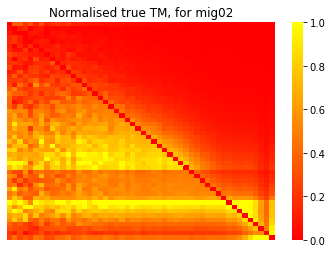

In [6]:
path =  '/home/trevor/ancestry/coal_data/pscmatch20201214/'
files = os.listdir(path)
print('Files are:\m')
for i in range(len(files)):
    print(f'File {i} is {path + files[i]}')
seq_length = 150e+06 # length of sequence used for simulations
all_tms = np.zeros(shape=(N_T,N_T))

for i in range(len(files)):
    print('on iteration {} of {}; file is {}'.format(i,len(files),files[i]))
    coal_data = np.loadtxt(path+files[i],comments="#")
    coal_times = round_bin_coal_data(seq_length,coal_data, args)
    coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)
    tm = tm_counts(coal_times_intervals,N_T=N_T)
    all_tms = all_tms + tm
    print(f'sum of all_tms is {sum(all_tms)}')
#     del tm, coal_data, coal_times, coal_times_intervals

tm_norm = normalise(all_tms,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd = np.copy(tm_norm)
tm_nd[range(0,len(tm_nd)),range(0,len(tm_nd))] = 0

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd,'colmax'),title='Normalised true TM, for mig02') # show heatmap


In [7]:
del path, files, tm_nd, tm_norm

Files are:\m
File 0 is /home/trevor/ancestry/coal_data/constmig20201214/constmig20201214_195357.txt
File 1 is /home/trevor/ancestry/coal_data/constmig20201214/constmig20201214_195823.txt
File 2 is /home/trevor/ancestry/coal_data/constmig20201214/constmig20201214_200207.txt
File 3 is /home/trevor/ancestry/coal_data/constmig20201214/constmig20201214_203657.txt
File 4 is /home/trevor/ancestry/coal_data/constmig20201214/constmig20201214_204047.txt
File 5 is /home/trevor/ancestry/coal_data/constmig20201214/constmig20201214_204502.txt
File 6 is /home/trevor/ancestry/coal_data/constmig20201214/constmig20201214_204913.txt
File 7 is /home/trevor/ancestry/coal_data/constmig20201214/constmig20201214_205337.txt
File 8 is /home/trevor/ancestry/coal_data/constmig20201214/constmig20201214_205850.txt
File 9 is /home/trevor/ancestry/coal_data/constmig20201214/constmig20201214_210353.txt
File 10 is /home/trevor/ancestry/coal_data/constmig20201214/constmig20201214_210801.txt
File 11 is /home/trevor/ances

sum of all_tms is [861481.  73020.  91387.  93115. 119981. 107514. 138889. 151293. 169925.
 171291. 178614. 222786. 241969. 256748. 284512. 291444. 329420. 359034.
 386531. 409431. 456309. 485675. 526813. 546186. 585780. 623706. 667691.
 720615. 734580. 757871. 784122. 808075. 821490. 828647. 487715. 436534.
 457246. 472856. 476162. 493857. 581660. 925155. 818229. 720138. 589712.
 483777. 377391. 290628. 212086. 390894.]
on iteration 15 of 20; file is constmig20201214_213027.txt
sum of all_tms is [909683.  77646.  98113. 100338. 128847. 117707. 147191. 162261. 183871.
 183974. 191346. 235384. 254486. 275628. 304971. 311967. 354081. 384177.
 414103. 437443. 485716. 518427. 560423. 582420. 630565. 666037. 711913.
 768857. 782148. 808555. 838488. 859824. 875792. 883117. 521643. 465035.
 486967. 503167. 507990. 524598. 619886. 986861. 873633. 766384. 629034.
 514905. 402361. 309731. 226218. 416072.]
on iteration 16 of 20; file is constmig20201214_213403.txt
sum of all_tms is [ 979945.   81

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


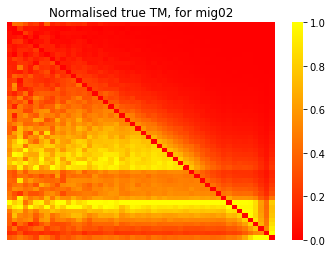

In [8]:
path =  '/home/trevor/ancestry/coal_data/constmig20201214/'
files = os.listdir(path)
print('Files are:\m')
for i in range(len(files)):
    print(f'File {i} is {path + files[i]}')
seq_length = 150e+06 # length of sequence used for simulations
all_tms = np.zeros(shape=(N_T,N_T))

for i in range(len(files)):
    print('on iteration {} of {}; file is {}'.format(i,len(files),files[i]))
    coal_data = np.loadtxt(path+files[i],comments="#")
    coal_times = round_bin_coal_data(seq_length,coal_data, args)
    coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)
    tm = tm_counts(coal_times_intervals,N_T=N_T)
    all_tms = all_tms + tm
    print(f'sum of all_tms is {sum(all_tms)}')
#     del tm, coal_data, coal_times, coal_times_intervals

tm_norm = normalise(all_tms,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd = np.copy(tm_norm)
tm_nd[range(0,len(tm_nd)),range(0,len(tm_nd))] = 0

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd,'colmax'),title='Normalised true TM, for mig02') # show heatmap


## Contmig5e5

In [21]:
path =  '/home/trevor/ancestry/coal_data/contmig5e5/'
files = os.listdir(path)
print('Files are:\m')
for i in range(len(files)):
    print(f'File {i} is {path + files[i]}')
seq_length = 150e+06 # length of sequence used for simulations
all_tms = np.zeros(shape=(N_T,N_T))


Files are:\m
File 0 is /home/trevor/ancestry/coal_data/contmig5e5/constmig_m5e05_111926.txt
File 1 is /home/trevor/ancestry/coal_data/contmig5e5/constmig_m5e05_114830.txt
File 2 is /home/trevor/ancestry/coal_data/contmig5e5/constmig_m5e05_115148.txt
File 3 is /home/trevor/ancestry/coal_data/contmig5e5/constmig_m5e05_115504.txt
File 4 is /home/trevor/ancestry/coal_data/contmig5e5/constmig_m5e05_115818.txt
File 5 is /home/trevor/ancestry/coal_data/contmig5e5/constmig_m5e05_120131.txt
File 6 is /home/trevor/ancestry/coal_data/contmig5e5/constmig_m5e05_120447.txt
File 7 is /home/trevor/ancestry/coal_data/contmig5e5/constmig_m5e05_120801.txt
File 8 is /home/trevor/ancestry/coal_data/contmig5e5/constmig_m5e05_121116.txt
File 9 is /home/trevor/ancestry/coal_data/contmig5e5/constmig_m5e05_121437.txt
File 10 is /home/trevor/ancestry/coal_data/contmig5e5/constmig_m5e05_121800.txt
File 11 is /home/trevor/ancestry/coal_data/contmig5e5/constmig_m5e05_122120.txt
File 12 is /home/trevor/ancestry/coal

on iteration 0 of 21; file is constmig_m5e05_111926.txt
sum of all_tms is [40681.  7044.  4357.  8437.  6948.  9235. 10340. 10507. 10281. 13518.
 11292. 13704. 17165. 13631. 20610. 22106. 19988. 23096. 26223. 29439.
 29460. 31416. 34093. 39146. 40287. 39660. 48262. 47993. 50649. 51214.
 51442. 53860. 56041. 56747. 49124. 43383. 38227. 31883. 29511. 28031.
 26579. 27518. 27627. 26222. 31662. 52493. 42322. 30950. 23032. 42563.]
on iteration 1 of 21; file is constmig_m5e05_114830.txt
sum of all_tms is [ 85219.  14279.  12638.  17344.  14978.  18613.  16521.  21926.  20231.
  24771.  25254.  25010.  31860.  32784.  39847.  46395.  40397.  48456.
  49977.  56450.  57318.  65079.  72241.  75044.  77786.  82554.  93132.
  96976.  98407. 103006. 104956. 110111. 110055. 112794.  97110.  85255.
  74535.  62802.  59296.  56780.  54930.  55583.  55046.  53445.  61268.
 104520.  83843.  62392.  46105.  84679.]
on iteration 2 of 21; file is constmig_m5e05_115148.txt
sum of all_tms is [132583.  23160

sum of all_tms is [ 963208.  127512.  116287.  129034.  145449.  150869.  159082.  180842.
  205353.  236967.  242937.  271396.  304084.  331946.  366365.  388870.
  426421.  452661.  493492.  525026.  576129.  608844.  655783.  708909.
  756636.  789008.  862531.  894452.  938908.  957416. 1000602. 1025662.
 1032169. 1064190.  938511.  793344.  678435.  605171.  560046.  539712.
  526434.  532070.  518647.  518605.  584499.  994049.  779995.  597358.
  437572.  806493.]
on iteration 19 of 21; file is constmig_m5e05_124815.txt
sum of all_tms is [1016573.  131551.  120648.  136066.  151851.  156648.  172378.  191761.
  215638.  249299.  254492.  284646.  319456.  348234.  385304.  409789.
  445251.  475076.  520764.  552058.  605460.  638839.  690435.  746357.
  795394.  831135.  910157.  942012.  991426. 1012366. 1054069. 1080035.
 1088428. 1120135.  990798.  835480.  711936.  636799.  589862.  567957.
  554643.  557969.  544114.  546031.  614043. 1045660.  822381.  629769.
  460247.  

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


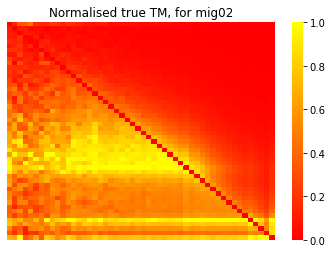

In [22]:

for i in range(len(files)):
    print('on iteration {} of {}; file is {}'.format(i,len(files),files[i]))
    coal_data = np.loadtxt(path+files[i],comments="#")
    coal_times = round_bin_coal_data(seq_length,coal_data, args)
    coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)
    tm = tm_counts(coal_times_intervals,N_T=N_T)
    all_tms = all_tms + tm
    print(f'sum of all_tms is {sum(all_tms)}')
#     del tm, coal_data, coal_times, coal_times_intervals

mig_all = all_tms
    
tm_norm = normalise(all_tms,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd = np.copy(tm_norm)
tm_nd[range(0,len(tm_nd)),range(0,len(tm_nd))] = 0

mig_all_nd = tm_nd

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd,'colmax'),title='Normalised true TM, for mig02') # show heatmap


In [23]:
del path, files, tm_nd, tm_norm

In [24]:
path =  '/home/trevor/ancestry/coal_data/psc_match5e05/'
files = os.listdir(path)
print('Files are:\m')
for i in range(len(files)):
    print(f'File {i} is {path + files[i]}')
seq_length = 150e+06 # length of sequence used for simulations
all_tms = np.zeros(shape=(N_T,N_T))


Files are:\m
File 0 is /home/trevor/ancestry/coal_data/psc_match5e05/psc_matching_mig5e05_113711.txt
File 1 is /home/trevor/ancestry/coal_data/psc_match5e05/psc_matching_mig5e05_121036.txt
File 2 is /home/trevor/ancestry/coal_data/psc_match5e05/psc_matching_mig5e05_121352.txt
File 3 is /home/trevor/ancestry/coal_data/psc_match5e05/psc_matching_mig5e05_121704.txt
File 4 is /home/trevor/ancestry/coal_data/psc_match5e05/psc_matching_mig5e05_122016.txt
File 5 is /home/trevor/ancestry/coal_data/psc_match5e05/psc_matching_mig5e05_122333.txt
File 6 is /home/trevor/ancestry/coal_data/psc_match5e05/psc_matching_mig5e05_122649.txt
File 7 is /home/trevor/ancestry/coal_data/psc_match5e05/psc_matching_mig5e05_123004.txt
File 8 is /home/trevor/ancestry/coal_data/psc_match5e05/psc_matching_mig5e05_123312.txt
File 9 is /home/trevor/ancestry/coal_data/psc_match5e05/psc_matching_mig5e05_123630.txt
File 10 is /home/trevor/ancestry/coal_data/psc_match5e05/psc_matching_mig5e05_123952.txt
File 11 is /home/t

on iteration 0 of 21; file is psc_matching_mig5e05_113711.txt
sum of all_tms is [52706.  3543.  9375.  4027.  9720.  8888. 10763.  9554. 11503. 13235.
  9533. 16371. 15900. 16529. 20704. 21788. 20372. 23747. 22408. 27483.
 28501. 31697. 33614. 35466. 40211. 44382. 43340. 47175. 48411. 49923.
 52991. 52613. 52563. 55828. 49006. 44760. 40617. 33775. 30250. 28319.
 28574. 26356. 27771. 25466. 31239. 53001. 40938. 30217. 22680. 42166.]
on iteration 1 of 21; file is psc_matching_mig5e05_121036.txt
sum of all_tms is [134497.   8641.  15432.  11553.  19122.  18379.  21409.  20619.  19192.
  25441.  22942.  31168.  28591.  32590.  37559.  40542.  42206.  45735.
  46647.  56724.  53490.  61340.  67757.  73614.  79477.  90847.  87719.
  93428.  97450.  98256. 103321. 102457. 105590. 111374.  95278.  87437.
  80076.  67787.  59605.  57632.  55499.  52660.  53519.  51282.  61776.
 102594.  81411.  61081.  43927.  83325.]
on iteration 2 of 21; file is psc_matching_mig5e05_121352.txt
sum of all_tms 

sum of all_tms is [884934. 100665.  96557. 113756. 142328. 147766. 161214. 180660. 190759.
 221392. 238451. 264033. 286909. 311697. 336608. 372944. 391279. 426049.
 465850. 507321. 539869. 607521. 626684. 683909. 727578. 758800. 809121.
 846865. 887963. 913243. 947266. 960396. 991955. 993372. 874240. 791104.
 697474. 620491. 547956. 523222. 487465. 486466. 477584. 466623. 542402.
 920506. 727949. 550936. 406552. 743298.]
on iteration 18 of 21; file is psc_matching_mig5e05_130538.txt
sum of all_tms is [ 946084.  104828.  101892.  120962.  148773.  151971.  168812.  190281.
  201504.  229792.  256271.  275639.  305358.  331999.  351402.  392902.
  413033.  452913.  490390.  537113.  569305.  638384.  659555.  723600.
  770741.  802586.  854855.  893086.  938505.  964446. 1003447. 1011981.
 1047489. 1044282.  922995.  834827.  736833.  654210.  576894.  552151.
  513914.  513311.  504650.  492580.  572097.  970719.  768561.  580534.
  428189.  783335.]
on iteration 19 of 21; file is psc_m

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


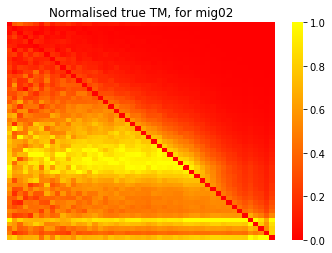

In [25]:
for i in range(len(files)):
    print('on iteration {} of {}; file is {}'.format(i,len(files),files[i]))
    coal_data = np.loadtxt(path+files[i],comments="#")
    coal_times = round_bin_coal_data(seq_length,coal_data, args)
    coal_times_intervals = round_coal_times(coal_times,T_scaled_np,N_T)
    tm = tm_counts(coal_times_intervals,N_T=N_T)
    all_tms = all_tms + tm
    print(f'sum of all_tms is {sum(all_tms)}')
#     del tm, coal_data, coal_times, coal_times_intervals

psc_all = all_tms

tm_norm = normalise(all_tms,'colsum') # normalise this such that it represents a probability distribution

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd = np.copy(tm_norm)
tm_nd[range(0,len(tm_nd)),range(0,len(tm_nd))] = 0

psc_all_nd = tm_nd

# TODO left-most and upper-most column look strange - try and fix. Update, think this is ok
heatmaps_seq(normalise(tm_nd,'colmax'),title='Normalised true TM, for mig02') # show heatmap


### compare these two

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


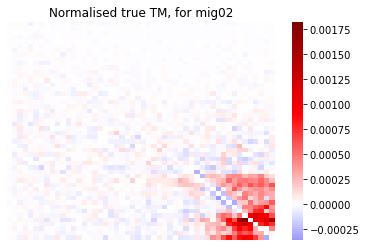

In [26]:
diff_nd = psc_all_nd - mig_all_nd
# heatmaps
heatmaps_div(diff_nd,title='Normalised true TM, for mig02') # show heatmap


In [19]:
T_scaled_np


array([     0.        ,    735.75888234,    813.42038634,    899.27928944,
          994.20085113,   1099.14166153,   1215.15928169,   1343.42290131,
         1485.22512147,   1641.9949811 ,   1815.31235837,   2006.92389221,
         2218.76058439,   2452.95725959,   2711.87407948,   2998.12032771,
         3314.58070543,   3664.44440247,   4051.23723698,   4478.85718752,
         4951.61367571,   5474.27099526,   6052.09632498,   6690.91280986,
         7397.15824489,   8177.94995315,   9041.15651202,   9995.47705026,
        11050.52891512,  12216.94459303,  13506.47886048,  14932.12724502,
        16508.25699021,  18250.75184418,  20177.17213123,  22306.93171926,
        24661.49366677,  27264.58652092,  30142.4434465 ,  33324.06659564,
        36841.5193825 ,  40730.24960852,  45029.44669433,  49782.43661864,
        55037.11854405,  60846.44753001,  67268.9681975 ,  74369.40472367,
        82219.31311201,  90897.80231171, 100492.3314531 ])